CMIP7 aerosol for ESM1.6 piControl

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import iris_tools as itools
import iris.plot as iplt
import xarray_tools as xrt
import cartopy.crs as ccrs
import iris
import cftime
from pathlib import Path
from notebook_metadata import create_savefig

savefig = create_savefig(dir='/scratch/tm70/mrd599', nb='cmip7_PI_aerosol.ipynb')

In [ ]:
from dask.distributed import Client
client = Client(threads_per_worker = 1)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40707 instead
  warnings.warn(


2025-06-04 12:31:29,252 - distributed.nanny - WARNING - Restarting worker
2025-06-04 12:31:29,255 - distributed.nanny - WARNING - Restarting worker
2025-06-04 12:31:29,330 - distributed.nanny - WARNING - Restarting worker
2025-06-04 12:31:29,334 - distributed.nanny - WARNING - Restarting worker
2025-06-04 12:31:29,634 - distributed.nanny - WARNING - Restarting worker
2025-06-04 12:31:29,637 - distributed.nanny - WARNING - Restarting worker
2025-06-04 12:31:30,649 - distributed.nanny - WARNING - Restarting worker
2025-06-04 12:31:30,652 - distributed.nanny - WARNING - Restarting worker


In [3]:
# For CMIP6 and CMIP7 data
t1 = cftime.DatetimeNoLeap(1850,1,1)
t2 = cftime.DatetimeNoLeap(1850,12,31)
constraint_1850 = iris.Constraint(time=lambda cell: t1 <= cell.point < t2)

# Sulfate

In [4]:
# ESM1.5 emissions have incorrect dates that break iris loading.
# Original files in /g/data/vk83/configurations/inputs/access-esm1p5/modern/pre-industrial/atmosphere/aerosol/global.N96/2020.05.19/
# Fixed by fix_ESM15_PI_aerosol.py

esm15_path = Path('/g/data/tm70/mrd599/esm15_aerosols')
so2_esm15_lo = iris.load_cube(esm15_path / 'scycl_1850_ESM1_v4.anc',
      'tendency_of_atmosphere_mass_content_of_sulfur_dioxide_expressed_as_sulfur_due_to_low_level_emission')
so2_esm15_hi = iris.load_cube(esm15_path / 'scycl_1850_ESM1_v4.anc',
      'tendency_of_atmosphere_mass_content_of_sulfur_dioxide_expressed_as_sulfur_due_to_high_level_emission')

so2_esm15_lo_a = itools.annual_mean(so2_esm15_lo)
so2_esm15_hi_a = itools.annual_mean(so2_esm15_hi)
so2_esm15_tot = so2_esm15_lo_a + so2_esm15_hi_a
area_esm15 = iris.load_cube('/g/data/fs38/publications/CMIP6/CMIP/CSIRO/ACCESS-ESM1-5/piControl/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-ESM1-5_piControl_r1i1p1f1_gn.nc')


In [5]:
# Select 1850 only and remove the level dimension
cm2_path = Path('/g/data/access/TIDS/CMIP6_ANCIL/users/bosley/ancils_N96e')
so2_cm2_lo = iris.load_cube(cm2_path / 'ukca_emiss_SO2_low_1850.nc')[:,0]
so2_cm2_hi = iris.load_cube(cm2_path / 'ukca_emiss_SO2_high_1850.nc')[:,0]

so2_cm2_lo_a = itools.annual_mean(so2_cm2_lo)
so2_cm2_hi_a = itools.annual_mean(so2_cm2_hi)
so2_cm2_tot = so2_cm2_lo_a + so2_cm2_hi_a
area_cm2 = iris.load_cube('/g/data/fs38/publications/CMIP6/CMIP/CSIRO-ARCCSS/ACCESS-CM2/piControl/r1i1p1f1/fx/areacella/gn/latest/areacella_fx_ACCESS-CM2_piControl_r1i1p1f1_gn.nc')


In [6]:
# Abbreviated names
sectors = ['Agriculture', 'Energy', 'Industrial', 'Transportation', 'RCO', 'Solvents', 'Waste', 'Shipping']

In [7]:
def cmip6_path(var):
    base = Path('/g/data/qv56/replicas/input4MIPs/CMIP6/CMIP/PNNL-JGCRI/CEDS-2017-05-18/atmos/mon')
    return base / f'{var}-em-anthro/gn/v20170519/{var}-em-anthro_input4MIPs_emissions_CMIP_CEDS-2017-05-18_gn_185001-185012.nc'

so2_cmip6 = iris.load_cube(cmip6_path('SO2'))
# Iris doesn't read the sector coordinate so use xarray for this
d = xr.open_dataset(cmip6_path('SO2')).sector
sectord = {}
for s in d.sector.ids.split(';'):
    i, name = s.split(':')
    sectord[name.strip()] = int(i)
d.close()

# High level emissions are assumed to be energy + 0.5*industrial sectors
# https://code.metoffice.gov.uk/trac/ancil/wiki/CMIP6/ForcingData/AerosolChemistryEmissions

so2_hi_cmip6 = so2_cmip6[:,sectord['Energy']] + 0.5*so2_cmip6[:,sectord['Industrial']]
so2_tot_cmip6 = so2_cmip6.collapsed(['sector'], iris.analysis.SUM)
so2_lo_cmip6 = so2_tot_cmip6 - so2_hi_cmip6

so2_hi_cmip6_a = itools.annual_mean(so2_hi_cmip6)
so2_tot_cmip6_a = itools.annual_mean(so2_tot_cmip6)
so2_lo_cmip6_a = itools.annual_mean(so2_lo_cmip6)

so2_hi_cmip6_g = itools.global_sum(so2_hi_cmip6)
so2_tot_cmip6_g = itools.global_sum(so2_tot_cmip6)
so2_cmip6_g = itools.global_sum(so2_cmip6)

so2_hi_cmip6_ga = itools.annual_mean(so2_hi_cmip6_g)
so2_tot_cmip6_ga = itools.annual_mean(so2_tot_cmip6_g)
so2_cmip6_ga = itools.annual_mean(so2_cmip6_g)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [8]:
def cmip7_path(var):
    base  = Path('/g/data/qv56/replicas/input4MIPs/CMIP7/CMIP/PNNL-JGCRI/CEDS-CMIP-2025-03-18/atmos/mon')
    return base / f'{var}_em_anthro/gn/v20250325/{var}-em-anthro_input4MIPs_emissions_CMIP_CEDS-CMIP-2025-03-18_gn_185001-189912.nc'

so2_cmip7 = iris.load_cube(cmip7_path('SO2'), constraint_1850)

so2_hi_cmip7 = so2_cmip7[:,sectord['Energy']] + 0.5*so2_cmip7[:,sectord['Industrial']]
so2_tot_cmip7 = so2_cmip7.collapsed(['sector'], iris.analysis.SUM)
so2_lo_cmip7 = so2_tot_cmip7 - so2_hi_cmip7

so2_hi_cmip7_a = itools.annual_mean(so2_hi_cmip7)
so2_tot_cmip7_a = itools.annual_mean(so2_tot_cmip7)
so2_lo_cmip7_a = itools.annual_mean(so2_lo_cmip7)

so2_hi_cmip7_g = itools.global_sum(so2_hi_cmip7)
so2_tot_cmip7_g = itools.global_sum(so2_tot_cmip7)
so2_cmip7_g = itools.global_sum(so2_cmip7)

so2_hi_cmip7_ga = itools.annual_mean(so2_hi_cmip7_g)
so2_tot_cmip7_ga = itools.annual_mean(so2_tot_cmip7_g)
so2_cmip7_ga = itools.annual_mean(so2_cmip7_g)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


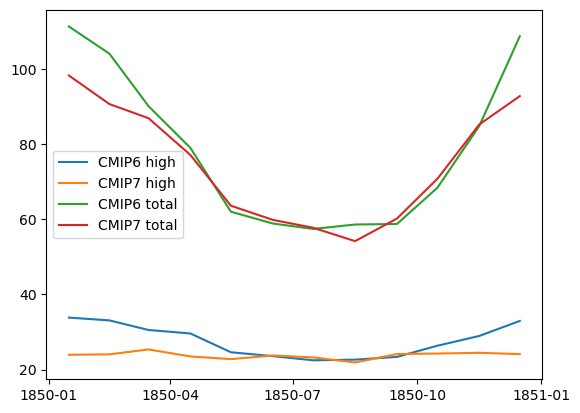

In [9]:
fig, axes = plt.subplots()
iplt.plot(so2_hi_cmip6_g, label='CMIP6 high')
iplt.plot(so2_hi_cmip7_g, label='CMIP7 high')
iplt.plot(so2_tot_cmip6_g, label='CMIP6 total')
iplt.plot(so2_tot_cmip7_g, label='CMIP7 total')
axes.legend()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 189.85 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


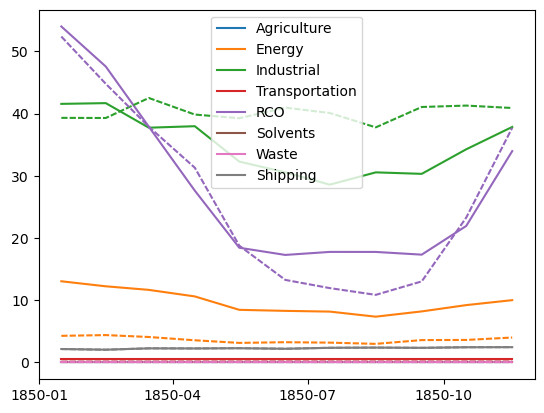

In [10]:
tmax=-1
fig, axes = plt.subplots()
for i, sector in enumerate(sectors):
    iplt.plot(so2_cmip6_g[:tmax,i],label=sector)
for i, sector in enumerate(sectors):
    iplt.plot(so2_cmip7_g[:tmax,i],color=f'C{i}', dashes=(3,1))
axes.legend()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encountered in log10
  return self.func(*new_argspec)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CMIP6 2.475
CMIP7 2.358
ESM1.5 2.478
CM2 2.483


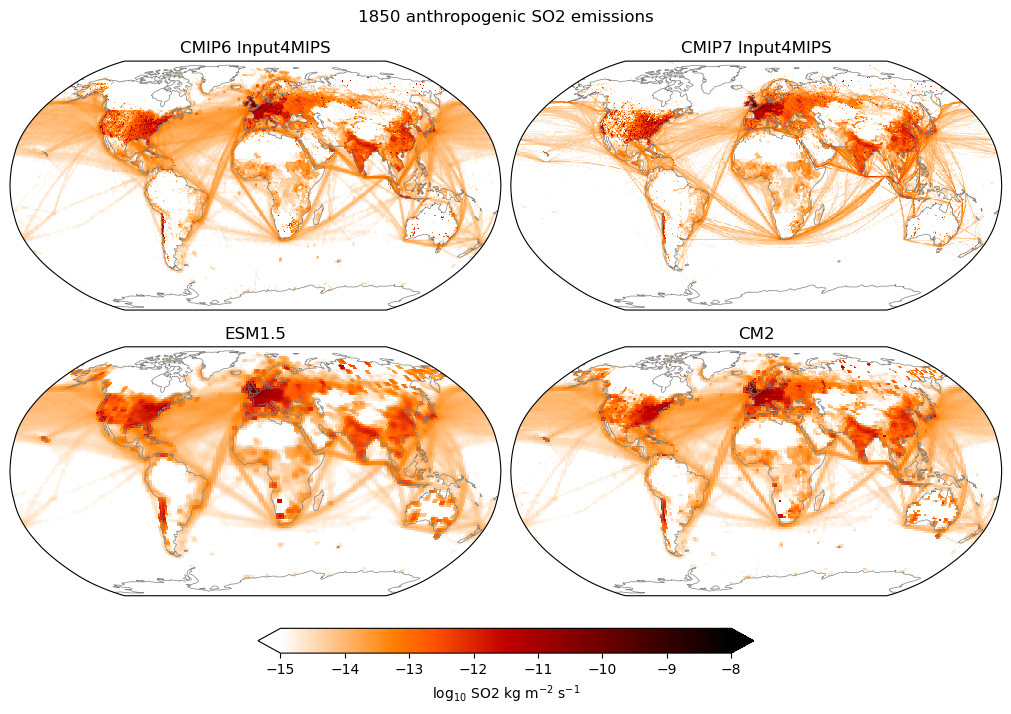

In [11]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic SO2 emissions')
vmin = -15
vmax= -8
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [so2_tot_cmip6_a, so2_tot_cmip7_a, 2*so2_esm15_tot, so2_cm2_tot]
label = ['CMIP6 Input4MIPS', 'CMIP7 Input4MIPS', 'ESM1.5', 'CM2']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    # p = np.log10(data[i]).plot(ax=ax,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ SO2 kg m$^{-2}$ s$^{-1}$')

savefig('so2_emissions.png')

print(f"CMIP6 {annfac*so2_tot_cmip6_ga[0].data:.3f}")
print(f"CMIP7 {annfac*so2_tot_cmip7_ga[0].data:.3f}")
# Here assuming a 360 day calendar
print(f"ESM1.5 {annfac*itools.global_sum(2*so2_esm15_tot[0]).data:.3f}")
print(f"CM2 {annfac*itools.global_sum(so2_cm2_tot[0]).data:.3f}")

In [49]:
# Match radius for global sum calculation
so2_lo_cmip6_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
so2_lo_cmip6_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
so2_hi_cmip6_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
so2_hi_cmip6_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


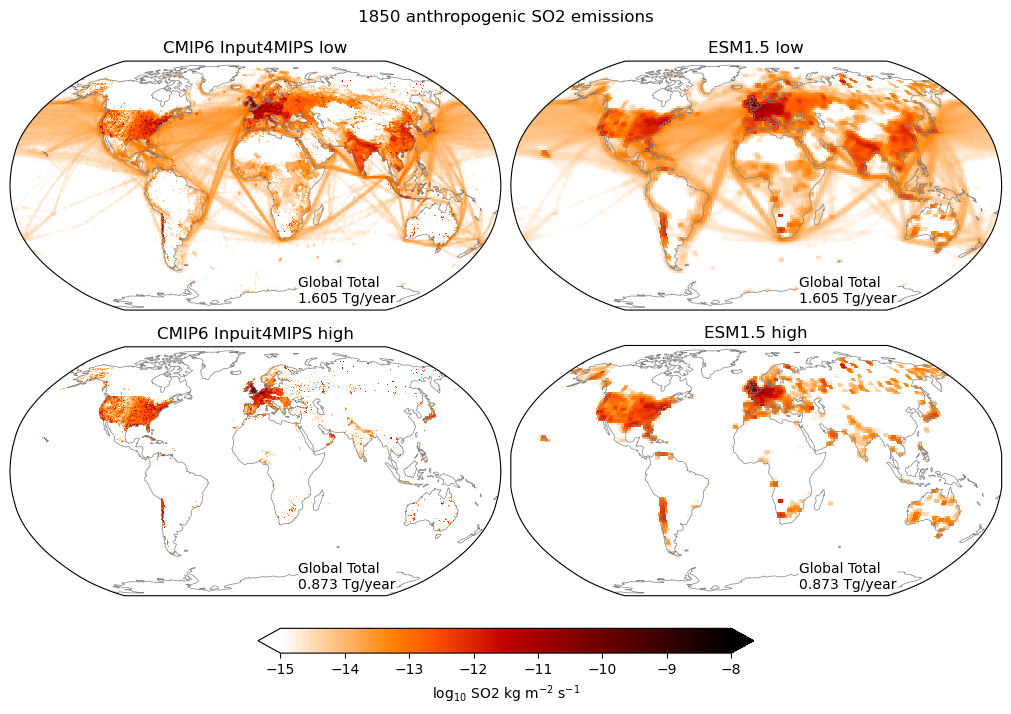

In [52]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic SO2 emissions')
vmin = -15
vmax= -8
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [so2_lo_cmip6_a, 2*so2_esm15_lo_a, so2_hi_cmip6_a, 2*so2_esm15_hi_a]
label = ['CMIP6 Input4MIPS low', 'ESM1.5 low', 'CMIP6 Inpuit4MIPS high', 'ESM1.5 high']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    # p = np.log10(data[i]).plot(ax=ax,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i][0]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ SO2 kg m$^{-2}$ s$^{-1}$')

savefig('so2_emissions_cmip6.png')

In [13]:
esm16_path = Path('/g/data/tm70/mrd599/esm16_aerosols')
so2_esm16_lo = iris.load_cube(esm16_path / 'scycl_1850_cmip7.anc',
      'tendency_of_atmosphere_mass_content_of_sulfur_dioxide_expressed_as_sulfur_due_to_low_level_emission')
so2_esm16_hi = iris.load_cube(esm16_path / 'scycl_1850_cmip7.anc',
      'tendency_of_atmosphere_mass_content_of_sulfur_dioxide_expressed_as_sulfur_due_to_high_level_emission')

so2_esm16_lo_a = itools.annual_mean(so2_esm16_lo)
so2_esm16_hi_a = itools.annual_mean(so2_esm16_hi)
so2_esm16_tot = so2_esm16_lo_a + so2_esm16_hi_a


In [ ]:
# Match radius for global sum calculation
so2_lo_cmip7_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
so2_lo_cmip7_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
so2_hi_cmip7_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
so2_hi_cmip7_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/dask/_task_spec.py:764: RuntimeWarning: divide by zero encoun

CMIP7 low  1.609
CMIP7 high 0.751
ESM1.6 low  1.609
ESM1.6 high 0.751


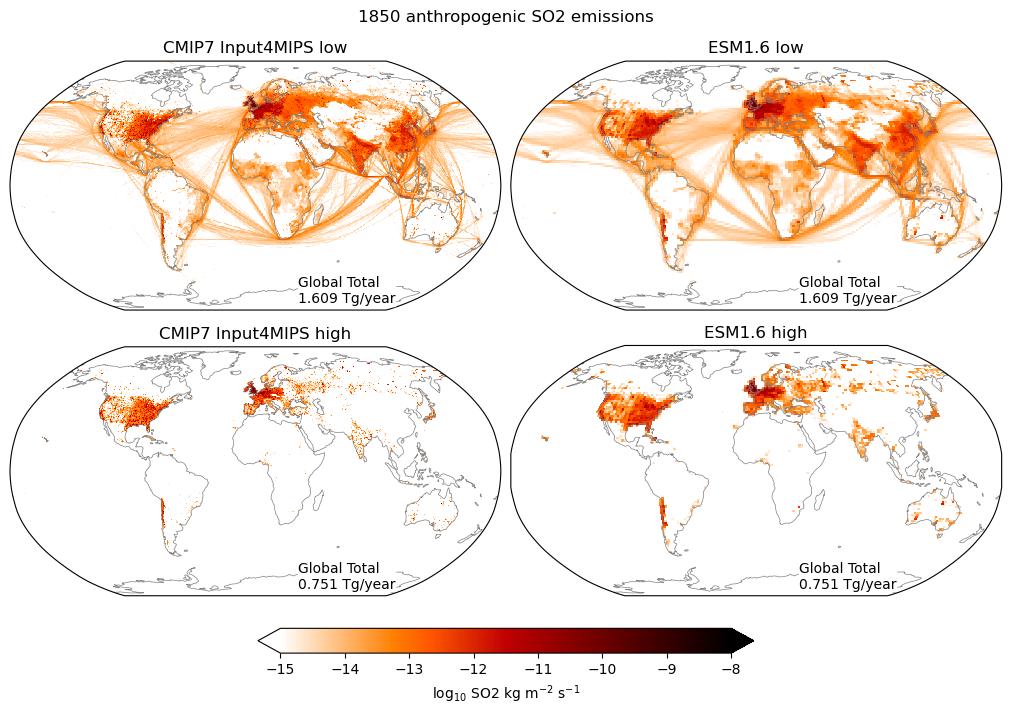

In [15]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic SO2 emissions')
vmin = -15
vmax= -8
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [so2_lo_cmip7_a, 2*so2_esm16_lo_a, so2_hi_cmip7_a, 2*so2_esm16_hi_a]
label = ['CMIP7 Input4MIPS low', 'ESM1.6 low', 'CMIP7 Input4MIPS high', 'ESM1.6 high']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    # p = np.log10(data[i]).plot(ax=ax,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i][0]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ SO2 kg m$^{-2}$ s$^{-1}$')

savefig('so2_emissions_cmip7_hilo.png')

print(f"CMIP7 low  {annfac*itools.global_sum(data[0][0]).data:.3f}")
print(f"CMIP7 high {annfac*itools.global_sum(data[2][0]).data:.3f}")
# Here assuming a 360 day calendar
print(f"ESM1.6 low  {annfac*itools.global_sum(data[1][0]).data:.3f}")
print(f"ESM1.6 high {annfac*itools.global_sum(data[3][0]).data:.3f}")

# Black Carbon

In [16]:
bc_esm15 = iris.load_cube(esm15_path / 'BC_hi_1850_ESM1.anc')
bc_esm15_a = itools.annual_mean(bc_esm15)

In [17]:
bc_cm2_biofuel = iris.load_cube(cm2_path / 'ukca_emiss_BC_biofuel_1850.nc')[:,0]
bc_cm2_fossil = iris.load_cube(cm2_path / 'ukca_emiss_BC_fossil_1850.nc')[:,0]
bc_cm2 = bc_cm2_biofuel + bc_cm2_fossil
bc_cm2_a = itools.annual_mean(bc_cm2)

In [18]:
bc_cmip6 = iris.load_cube(cmip6_path('BC'))

bc_tot_cmip6 = bc_cmip6.collapsed(['sector'], iris.analysis.SUM)

bc_tot_cmip6_a = itools.annual_mean(bc_tot_cmip6)
bc_tot_cmip6_g = itools.global_sum(bc_tot_cmip6)
bc_tot_cmip6_ga = itools.annual_mean(bc_tot_cmip6_g)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [19]:
bc_cmip7 = iris.load_cube(cmip7_path('BC'), constraint_1850)

bc_tot_cmip7 = bc_cmip7.collapsed(['sector'], iris.analysis.SUM)

bc_tot_cmip7_a = itools.annual_mean(bc_tot_cmip7)
bc_tot_cmip7_g = itools.global_sum(bc_tot_cmip7)
bc_tot_cmip7_ga = itools.annual_mean(bc_tot_cmip7_g)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.73 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


Text(0, 0.5, 'Tg/year')

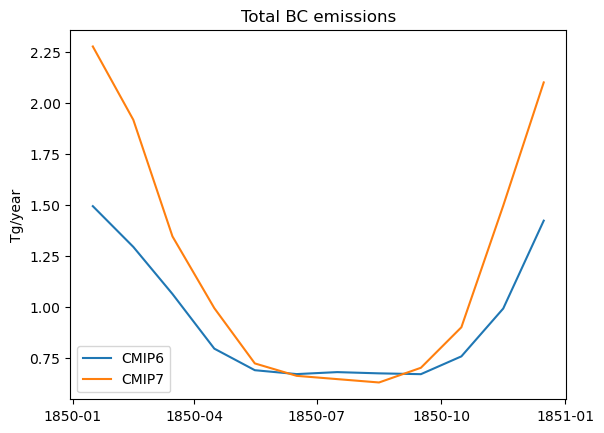

In [20]:
fig, axes = plt.subplots()
iplt.plot(annfac*bc_tot_cmip6_g, label='CMIP6')
iplt.plot(annfac*bc_tot_cmip7_g, label='CMIP7')
axes.set_title('Total BC emissions')
axes.legend()
axes.set_ylabel('Tg/year')

In [ ]:
# fig, axes = plt.subplots()
# tmax=-1
# for i, sector in enumerate(sectors):
#     iplt.plot(bc_cmip6_g[:tmax,i], label=sector)
# for i, sector in enumerate(sectors):
#     iplt.plot(bc_cmip7_g[:tmax,i], color=f'C{i}', dashes=(3,1))
# axes.legend()

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CMIP6 0.934
CMIP7 1.200
ESM1.5 0.935
CM2 0.936


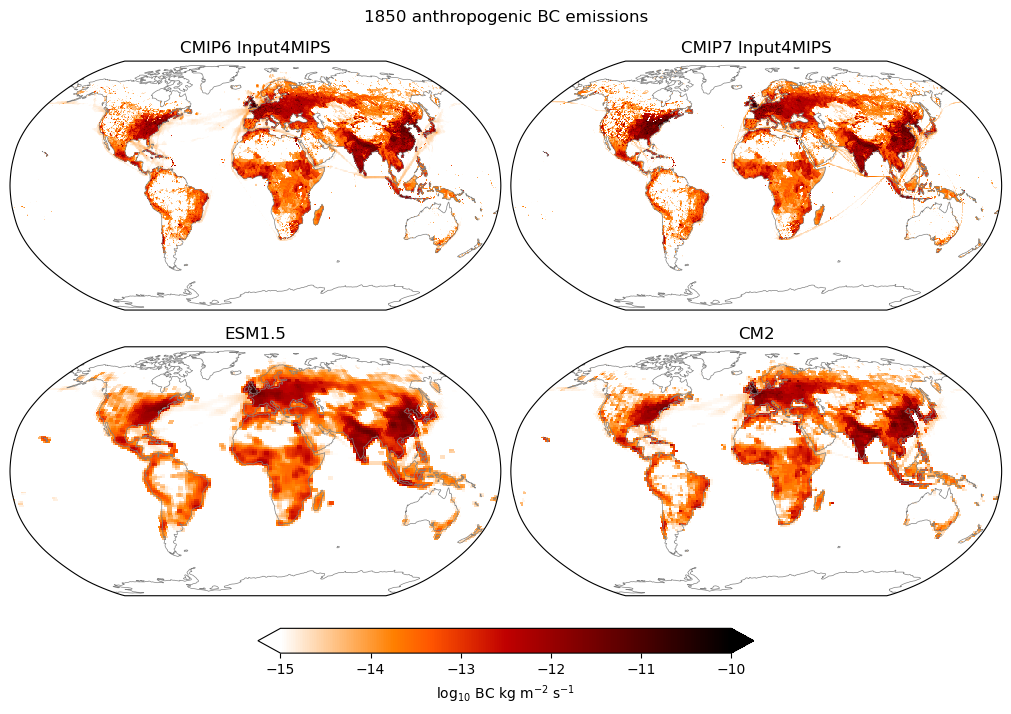

In [22]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic BC emissions')
vmin = -15
vmax= -10
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [bc_tot_cmip6_a, bc_tot_cmip7_a, bc_esm15_a, bc_cm2_a]
label = ['CMIP6 Input4MIPS', 'CMIP7 Input4MIPS', 'ESM1.5', 'CM2']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ BC kg m$^{-2}$ s$^{-1}$')

savefig('bc_emissions.png')

print(f"CMIP6 {annfac*bc_tot_cmip6_ga[0].data:.3f}")
print(f"CMIP7 {annfac*bc_tot_cmip7_ga[0].data:.3f}")
# Here assuming a 360 day calendar
print(f"ESM1.5 {annfac*itools.global_sum(bc_esm15_a[0]).data:.3f}")
print(f"CM2 {annfac*itools.global_sum(bc_cm2_a[0]).data:.3f}")


In [53]:
# Match radius for global sum calculation
bc_tot_cmip6_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bc_tot_cmip6_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


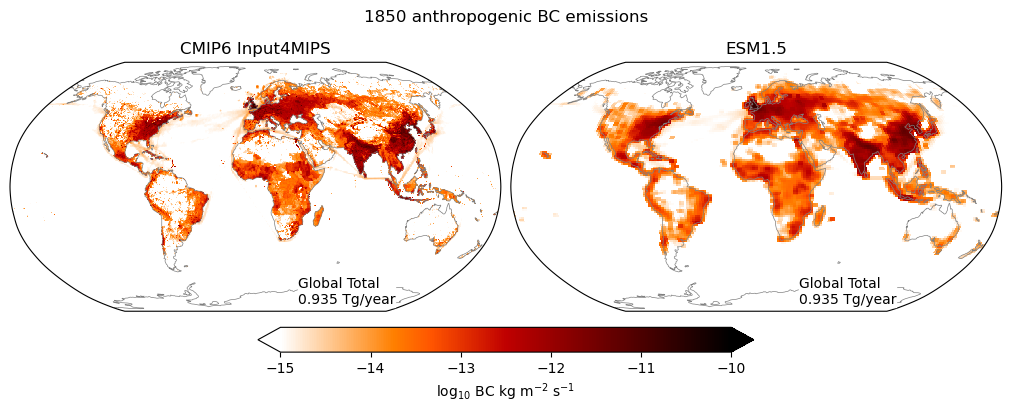

In [54]:
fig, axes = plt.subplots(1,2,layout='constrained', figsize=(10,4),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic BC emissions')
vmin = -15
vmax= -10
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [bc_tot_cmip6_a, bc_esm15_a]
label = ['CMIP6 Input4MIPS', 'ESM1.5']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i][0]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ BC kg m$^{-2}$ s$^{-1}$')

savefig('bc_emissions_cmip6.png')


In [23]:
bc_esm16 = iris.load_cube(esm16_path / 'BC_1850_cmip7.anc')
bc_esm16_a = itools.annual_mean(bc_esm16)

In [24]:
# Match radius for global sum calculation
bc_tot_cmip7_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bc_tot_cmip7_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CMIP7 1.200
ESM1.6 1.202


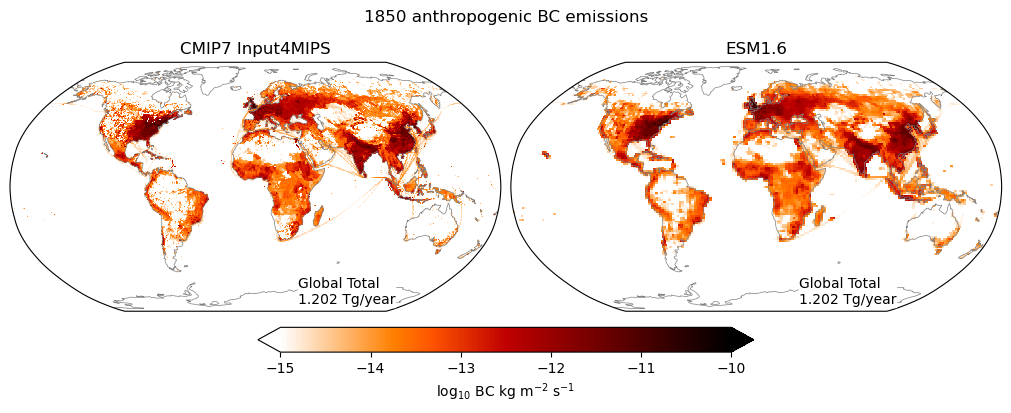

In [25]:
fig, axes = plt.subplots(1,2,layout='constrained', figsize=(10,4),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic BC emissions')
vmin = -15
vmax= -10
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [bc_tot_cmip7_a, bc_esm16_a]
label = ['CMIP7 Input4MIPS', 'ESM1.6']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i][0]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ BC kg m$^{-2}$ s$^{-1}$')

savefig('bc_emissions_cmip7.png')

print(f"CMIP7 {annfac*bc_tot_cmip7_ga[0].data:.3f}")
print(f"ESM1.6 {annfac*itools.global_sum(bc_esm16_a[0]).data:.3f}")


# Organic carbon

In [26]:
oc_esm15 = iris.load_cube(esm15_path / 'OCFF_1850_ESM1.anc')
oc_esm15_a = itools.annual_mean(oc_esm15)

In [27]:
oc_cm2_biofuel = iris.load_cube(cm2_path / 'ukca_emiss_OC_biofuel_1850.nc')[:,0]
oc_cm2_fossil = iris.load_cube(cm2_path / 'ukca_emiss_OC_fossil_1850.nc')[:,0]
oc_cm2 = oc_cm2_biofuel + oc_cm2_fossil
oc_cm2_a = itools.annual_mean(oc_cm2)

In [28]:
oc_cmip6 = iris.load_cube(cmip6_path('OC'))

oc_tot_cmip6 = oc_cmip6.collapsed(['sector'], iris.analysis.SUM)

oc_tot_cmip6_a = itools.annual_mean(oc_tot_cmip6)
oc_tot_cmip6_g = itools.global_sum(oc_tot_cmip6)
oc_tot_cmip6_ga = itools.annual_mean(oc_tot_cmip6_g)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [29]:
oc_cmip7 = iris.load_cube(cmip7_path('OC'), constraint_1850)

oc_tot_cmip7 = oc_cmip7.collapsed(['sector'], iris.analysis.SUM)

oc_tot_cmip7_a = itools.annual_mean(oc_tot_cmip7)
oc_tot_cmip7_g = itools.global_sum(oc_tot_cmip7)
oc_tot_cmip7_ga = itools.annual_mean(oc_tot_cmip7_g)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [30]:
# fig, axes = plt.subplots()
# (annfac*oc_tot_cmip6_g).plot(label='CMIP6')
# (annfac*oc_tot_cmip7_g).plot(label='CMIP7')
# axes.set_title('Total OC emissions')
# axes.legend()
# axes.set_ylabel('Tg/year')

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CMIP6 4.262
CMIP7 5.336
ESM1.5 4.267
CM2 4.270


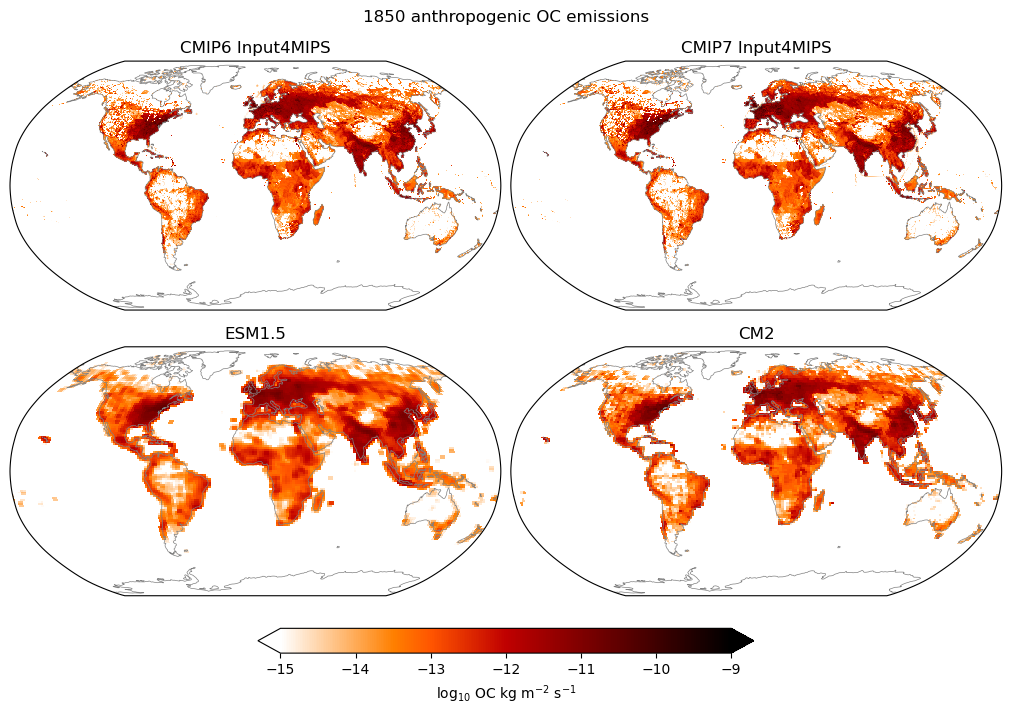

In [31]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic OC emissions')
vmin = -15
vmax= -9
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [oc_tot_cmip6_a, oc_tot_cmip7_a, oc_esm15_a, oc_cm2_a]
label = ['CMIP6 Input4MIPS', 'CMIP7 Input4MIPS', 'ESM1.5', 'CM2']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ OC kg m$^{-2}$ s$^{-1}$')

savefig('oc_emissions.png')

print(f"CMIP6 {annfac*oc_tot_cmip6_ga[0].data:.3f}")
print(f"CMIP7 {annfac*oc_tot_cmip7_ga[0].data:.3f}")
# Here assuming a 360 day calendar
print(f"ESM1.5 {annfac*itools.global_sum(oc_esm15_a[0]).data:.3f}")
print(f"CM2 {annfac*itools.global_sum(oc_cm2_a[0]).data:.3f}")


In [55]:
# Match radius for global sum calculation
oc_tot_cmip6_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
oc_tot_cmip6_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


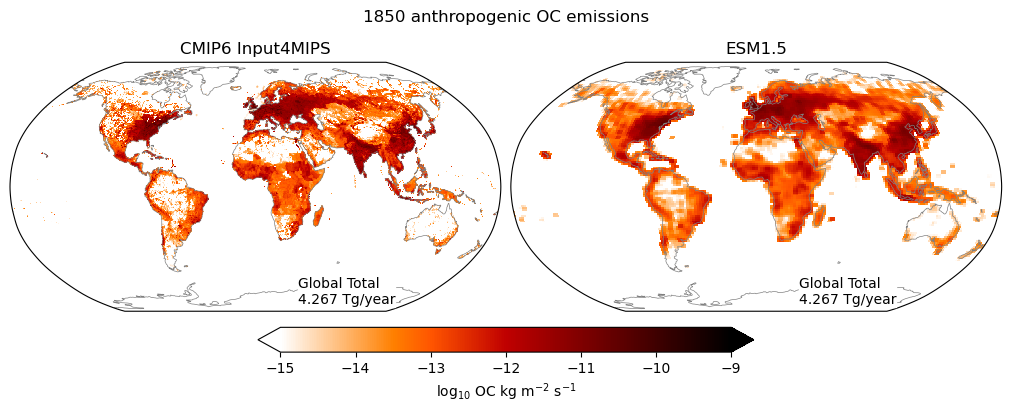

In [59]:
fig, axes = plt.subplots(1,2,layout='constrained', figsize=(10,4),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic OC emissions')
vmin = -15
vmax= -9
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [oc_tot_cmip6_a, oc_esm15_a]
label = ['CMIP6 Input4MIPS', 'ESM1.5']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i][0]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ OC kg m$^{-2}$ s$^{-1}$')

savefig('oc_emissions_cmip6.png')


In [32]:
oc_esm16 = iris.load_cube(esm16_path / 'OCFF_1850_cmip7.anc')
oc_esm16_a = itools.annual_mean(oc_esm16)

In [ ]:
# Match radius for global sum calculation
oc_tot_cmip7_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
oc_tot_cmip7_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 23.74 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CMIP7 5.336
ESM1.6 5.342


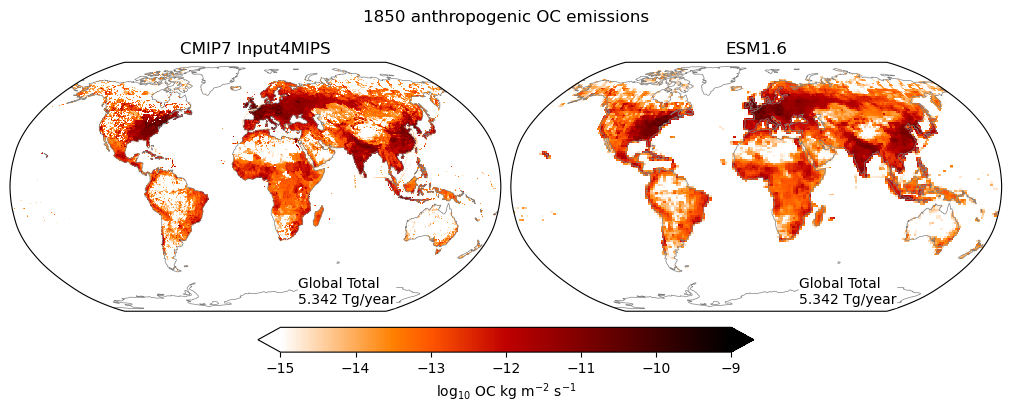

In [34]:
fig, axes = plt.subplots(1,2,layout='constrained', figsize=(10,4),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic OC emissions')
vmin = -15
vmax= -9
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [oc_tot_cmip7_a, oc_esm16_a]
label = ['CMIP7 Input4MIPS', 'ESM1.6']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i][0]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ OC kg m$^{-2}$ s$^{-1}$')

savefig('oc_emissions_cmip7.png')

print(f"CMIP7 {annfac*oc_tot_cmip7_ga[0].data:.3f}")
print(f"ESM1.6 {annfac*itools.global_sum(oc_esm16_a[0]).data:.3f}")


# Biomass burning

In [35]:
bb_esm15_lo = iris.load_cube(esm15_path / 'Bio_1850_ESM1.anc',
    'tendency_of_atmosphere_mass_content_of_biomass_burning_dry_aerosol_due_to_low_level_emission')
bb_esm15_hi = iris.load_cube(esm15_path / 'Bio_1850_ESM1.anc',
    'tendency_of_atmosphere_mass_content_of_biomass_burning_dry_aerosol_due_to_high_level_emission')

bb_esm15 = bb_esm15_lo + bb_esm15_hi
bb_esm15_a = itools.annual_mean(bb_esm15)
bb_esm15_lo_a = itools.annual_mean(bb_esm15_lo)
bb_esm15_hi_a = itools.annual_mean(bb_esm15_hi)

In [36]:
bc_cm2_biomass_high = iris.load_cube(cm2_path / 'ukca_emiss_BC_biomass_high_1850.nc')[:,0]
bc_cm2_biomass_low = iris.load_cube(cm2_path / 'ukca_emiss_BC_biomass_low_1850.nc')[:,0]
oc_cm2_biomass_high = iris.load_cube(cm2_path / 'ukca_emiss_OC_biomass_high_1850.nc')[:,0]
oc_cm2_biomass_low = iris.load_cube(cm2_path / 'ukca_emiss_OC_biomass_low_1850.nc')[:,0]

bb_cm2 = bc_cm2_biomass_high + bc_cm2_biomass_low + oc_cm2_biomass_high + oc_cm2_biomass_low
bb_cm2_a = itools.annual_mean(bb_cm2)


In [37]:
def cmip6_bb_path(var):
    base = Path('/g/data/qv56/replicas/input4MIPs/CMIP6/CMIP/VUA/VUA-CMIP-BB4CMIP6-1-2/atmos/mon')
    return base / f'{var}/gn/v20161213/{var}-em-biomassburning_input4MIPs_emissions_CMIP_VUA-CMIP-BB4CMIP6-1-2_gn_185001-201512.nc'

bb_bc_cmip6 = iris.load_cube(cmip6_bb_path('BC'), constraint_1850)
bb_oc_cmip6 = iris.load_cube(cmip6_bb_path('OC'), constraint_1850)

bb_cmip6 = bb_bc_cmip6 + bb_oc_cmip6
bb_cmip6_a = itools.annual_mean(bb_cmip6)
bb_cmip6_g = itools.global_sum(bb_cmip6)
bb_cmip6_ga = itools.annual_mean(bb_cmip6_g)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [38]:
# For the low/high split follow Met Office CMIP6
# low: AGRI, PEAT, SAVA
# high: BORF, DEFO, TEMF
def cmip6_bb_percent_path(var):
    base = Path('/g/data/qv56/replicas/input4MIPs/CMIP6/CMIP/VUA/VUA-CMIP-BB4CMIP6-1-2/atmos/mon')
    return base / f'{var}/gn/v20161213/{var}-em-biomassburning_input4MIPs_emissions_CMIP_VUA-CMIP-BB4CMIP6-1-2_gn_175001-201512.nc'

bb_bc_agri_cmip6 = iris.load_cube(cmip6_bb_percent_path('BC-percentage-AGRI'), constraint_1850)
bb_bc_peat_cmip6 = iris.load_cube(cmip6_bb_percent_path('BC-percentage-PEAT'), constraint_1850)
bb_bc_sava_cmip6 = iris.load_cube(cmip6_bb_percent_path('BC-percentage-SAVA'), constraint_1850)
bb_bc_borf_cmip6 = iris.load_cube(cmip6_bb_percent_path('BC-percentage-BORF'), constraint_1850)
bb_bc_defo_cmip6 = iris.load_cube(cmip6_bb_percent_path('BC-percentage-DEFO'), constraint_1850)
bb_bc_temf_cmip6 = iris.load_cube(cmip6_bb_percent_path('BC-percentage-TEMF'), constraint_1850)

bb_bc_frac_low_cmip6 = 0.01 * (bb_bc_agri_cmip6 + bb_bc_peat_cmip6 + bb_bc_sava_cmip6)
bb_bc_frac_high_cmip6 = 0.01 * (bb_bc_borf_cmip6 + bb_bc_defo_cmip6 + bb_bc_temf_cmip6)

bb_oc_agri_cmip6 = iris.load_cube(cmip6_bb_percent_path('OC-percentage-AGRI'), constraint_1850)
bb_oc_peat_cmip6 = iris.load_cube(cmip6_bb_percent_path('OC-percentage-PEAT'), constraint_1850)
bb_oc_sava_cmip6 = iris.load_cube(cmip6_bb_percent_path('OC-percentage-SAVA'), constraint_1850)
bb_oc_borf_cmip6 = iris.load_cube(cmip6_bb_percent_path('OC-percentage-BORF'), constraint_1850)
bb_oc_defo_cmip6 = iris.load_cube(cmip6_bb_percent_path('OC-percentage-DEFO'), constraint_1850)
bb_oc_temf_cmip6 = iris.load_cube(cmip6_bb_percent_path('OC-percentage-TEMF'), constraint_1850)

bb_oc_frac_low_cmip6 = 0.01 * (bb_oc_agri_cmip6 + bb_oc_peat_cmip6 + bb_oc_sava_cmip6)
bb_oc_frac_high_cmip6 = 0.01 * (bb_oc_borf_cmip6 + bb_oc_defo_cmip6 + bb_oc_temf_cmip6)

# Base times are different, so multiplying cubes doesn't work
bb_lo_cmip6 = bb_bc_cmip6*bb_bc_frac_low_cmip6.data + bb_oc_cmip6*bb_oc_frac_low_cmip6.data
bb_hi_cmip6 = bb_bc_cmip6*bb_bc_frac_high_cmip6.data + bb_oc_cmip6*bb_oc_frac_high_cmip6.data

bb_lo_cmip6_a = itools.annual_mean(bb_lo_cmip6)
bb_hi_cmip6_a = itools.annual_mean(bb_hi_cmip6)


In [39]:
def cmip7_bb_path(var):
    base = Path('/g/data/qv56/replicas/input4MIPs/CMIP7/CMIP/DRES/DRES-CMIP-BB4CMIP7-2-0/atmos/mon')
    return base / f'{var}/gn/v20250227/{var}_input4MIPs_emissions_CMIP_DRES-CMIP-BB4CMIP7-2-0_gn_175001-189912.nc'

bb_oc_cmip7 = iris.load_cube(cmip7_bb_path('OC'), constraint_1850)
bb_bc_cmip7 = iris.load_cube(cmip7_bb_path('BC'), constraint_1850)

bb_cmip7 = bb_bc_cmip7 + bb_oc_cmip7
bb_cmip7_a = itools.annual_mean(bb_cmip7)
bb_cmip7_g = itools.global_sum(bb_cmip7)
bb_cmip7_ga = itools.annual_mean(bb_cmip7_g)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'gridcellarea', referenced by netCDF variable 'OC'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'gridcellarea', referenced by netCDF variable 'BC'
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


In [40]:
# For the low/high split follow Met Office CMIP6
# low: AGRI, PEAT, SAVA
# high: BORF, DEFO, TEMF
def cmip7_bb_percent_path(var):
    base = Path('/g/data/qv56/replicas/input4MIPs/CMIP7/CMIP/DRES/DRES-CMIP-BB4CMIP7-2-0/atmos/mon')
    return base / f'{var}/gn/v20250227/{var}_input4MIPs_emissions_CMIP_DRES-CMIP-BB4CMIP7-2-0_gn_175001-202312.nc'

bb_bc_agri_cmip7 = iris.load_cube(cmip7_bb_percent_path('BCpercentageAGRI'), constraint_1850)
bb_bc_peat_cmip7 = iris.load_cube(cmip7_bb_percent_path('BCpercentagePEAT'), constraint_1850)
bb_bc_sava_cmip7 = iris.load_cube(cmip7_bb_percent_path('BCpercentageSAVA'), constraint_1850)
bb_bc_borf_cmip7 = iris.load_cube(cmip7_bb_percent_path('BCpercentageBORF'), constraint_1850)
bb_bc_defo_cmip7 = iris.load_cube(cmip7_bb_percent_path('BCpercentageDEFO'), constraint_1850)
bb_bc_temf_cmip7 = iris.load_cube(cmip7_bb_percent_path('BCpercentageTEMF'), constraint_1850)

bb_bc_frac_low_cmip7 = 0.01 * (bb_bc_agri_cmip7 + bb_bc_peat_cmip7 + bb_bc_sava_cmip7)
bb_bc_frac_high_cmip7 = 0.01 * (bb_bc_borf_cmip7 + bb_bc_defo_cmip7 + bb_bc_temf_cmip7)

bb_oc_agri_cmip7 = iris.load_cube(cmip7_bb_percent_path('OCpercentageAGRI'), constraint_1850)
bb_oc_peat_cmip7 = iris.load_cube(cmip7_bb_percent_path('OCpercentagePEAT'), constraint_1850)
bb_oc_sava_cmip7 = iris.load_cube(cmip7_bb_percent_path('OCpercentageSAVA'), constraint_1850)
bb_oc_borf_cmip7 = iris.load_cube(cmip7_bb_percent_path('OCpercentageBORF'), constraint_1850)
bb_oc_defo_cmip7 = iris.load_cube(cmip7_bb_percent_path('OCpercentageDEFO'), constraint_1850)
bb_oc_temf_cmip7 = iris.load_cube(cmip7_bb_percent_path('OCpercentageTEMF'), constraint_1850)

bb_oc_frac_low_cmip7 = 0.01 * (bb_oc_agri_cmip7 + bb_oc_peat_cmip7 + bb_oc_sava_cmip7)
bb_oc_frac_high_cmip7 = 0.01 * (bb_oc_borf_cmip7 + bb_oc_defo_cmip7 + bb_oc_temf_cmip7)

bb_lo_cmip7 = bb_bc_cmip7*bb_bc_frac_low_cmip7  + bb_oc_cmip7*bb_oc_frac_low_cmip7
bb_hi_cmip7 = bb_bc_cmip7*bb_bc_frac_high_cmip7 + bb_oc_cmip7*bb_oc_frac_high_cmip7

bb_lo_cmip7_a = itools.annual_mean(bb_lo_cmip7)
bb_hi_cmip7_a = itools.annual_mean(bb_hi_cmip7)


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 94.93 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CMIP6 15.564
CMIP7 15.564
ESM1.5 15.583
CM2 15.795


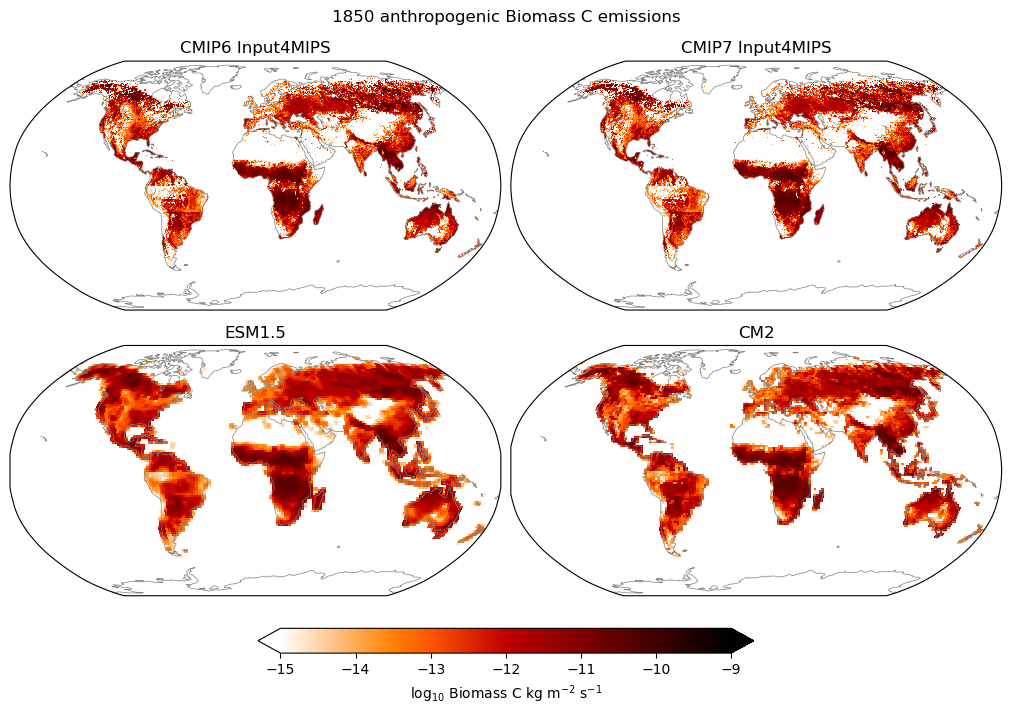

In [41]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic Biomass C emissions')
vmin = -15
vmax= -9
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [bb_cmip6_a, bb_cmip7_a, bb_esm15_a, bb_cm2_a]
label = ['CMIP6 Input4MIPS', 'CMIP7 Input4MIPS', 'ESM1.5', 'CM2']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ Biomass C kg m$^{-2}$ s$^{-1}$')

savefig('biomass_emissions.png')

print(f"CMIP6 {annfac*bb_cmip6_ga[0].data:.3f}")
print(f"CMIP7 {annfac*bb_cmip7_ga[0].data:.3f}")
# Here assuming a 360 day calendar
print(f"ESM1.5 {annfac*itools.global_sum(bb_esm15_a[0]).data:.3f}")
print(f"CM2 {annfac*itools.global_sum(bb_cm2_a[0]).data:.3f}")


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 118.66 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/numpy/ma/core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of 

CMIP6 low 9.115


/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/analysis/cartography.py:436: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 126.57 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(


CMIP6 high 6.449
ESM1.5 low 9.126
ESM1.5 high 6.457


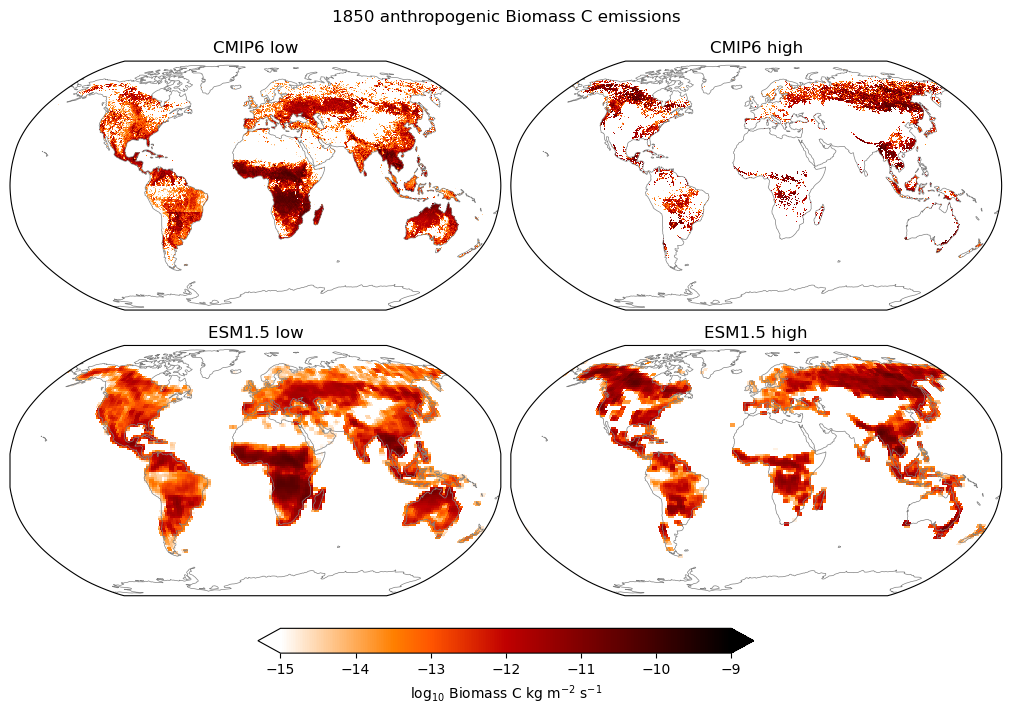

In [42]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic Biomass C emissions')
vmin = -15
vmax= -9
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [bb_lo_cmip6_a[0], bb_hi_cmip6_a[0], bb_esm15_lo_a[0], bb_esm15_hi_a[0]]
label = ['CMIP6 low', 'CMIP6 high', 'ESM1.5 low', 'ESM1.5 high']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ Biomass C kg m$^{-2}$ s$^{-1}$')

savefig('biomass_emissions.png')

print(f"CMIP6 low {annfac*itools.global_sum(data[0]).data:.3f}")
print(f"CMIP6 high {annfac*itools.global_sum(data[1]).data:.3f}")
# Here assuming a 360 day calendar
print(f"ESM1.5 low {annfac*itools.global_sum(data[2]).data:.3f}")
print(f"ESM1.5 high {annfac*itools.global_sum(data[3]).data:.3f}")


In [57]:
# Match radius for global sum calculation
bb_lo_cmip6_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bb_lo_cmip6_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bb_hi_cmip6_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bb_hi_cmip6_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 118.66 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/distributed/client.py:3363: UserWarning: Sending large graph of size 126.57 MiB.
This may cause some slowdown.
Consider loading the data with Dask directly
 or using futures or delayed objects to embed the data into the graph without repetition.
See also https://docs.dask.org/en/stable/best-practices.html#load-data-with-dask for more information.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.p

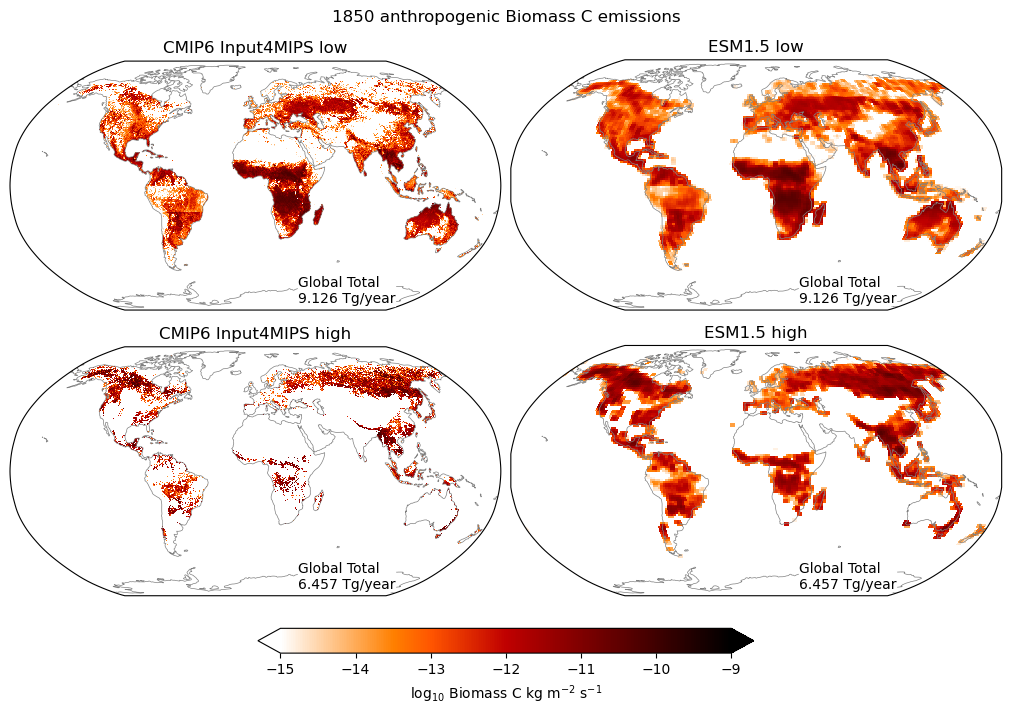

In [58]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic Biomass C emissions')
vmin = -15
vmax= -9
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [bb_lo_cmip6_a[0], bb_esm15_lo_a[0], bb_hi_cmip6_a[0], bb_esm15_hi_a[0]]
label = ['CMIP6 Input4MIPS low', 'ESM1.5 low', 'CMIP6 Input4MIPS high', 'ESM1.5 high']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ Biomass C kg m$^{-2}$ s$^{-1}$')

savefig('biomass_emissions_cmip6_hilo.png')


In [43]:
bb_esm16_lo = iris.load_cube(esm16_path / 'Bio_1850_cmip7.anc',
    'tendency_of_atmosphere_mass_content_of_biomass_burning_dry_aerosol_due_to_low_level_emission')
bb_esm16_hi = iris.load_cube(esm16_path / 'Bio_1850_cmip7.anc',
    'tendency_of_atmosphere_mass_content_of_biomass_burning_dry_aerosol_due_to_high_level_emission')

bb_esm16 = bb_esm16_lo + bb_esm16_hi
bb_esm16_a = itools.annual_mean(bb_esm16)
bb_esm16_lo_a = itools.annual_mean(bb_esm16_lo)
bb_esm16_hi_a = itools.annual_mean(bb_esm16_hi)

In [44]:
# Match radius for global sum calculation
bb_lo_cmip7_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bb_lo_cmip7_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bb_hi_cmip7_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bb_hi_cmip7_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'longitude' is not bounded, guessing contiguous bounds.
  warnings.warn(
/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/coords.py:1979: IrisGuessBoundsWarning: Coordinate 'latitude' is not bounded, guessing contiguous bounds.
  warnings.warn(


CMIP7 low 9.126
CMIP7 high 6.457
ESM1.6 low 9.126
ESM1.6 high 6.457


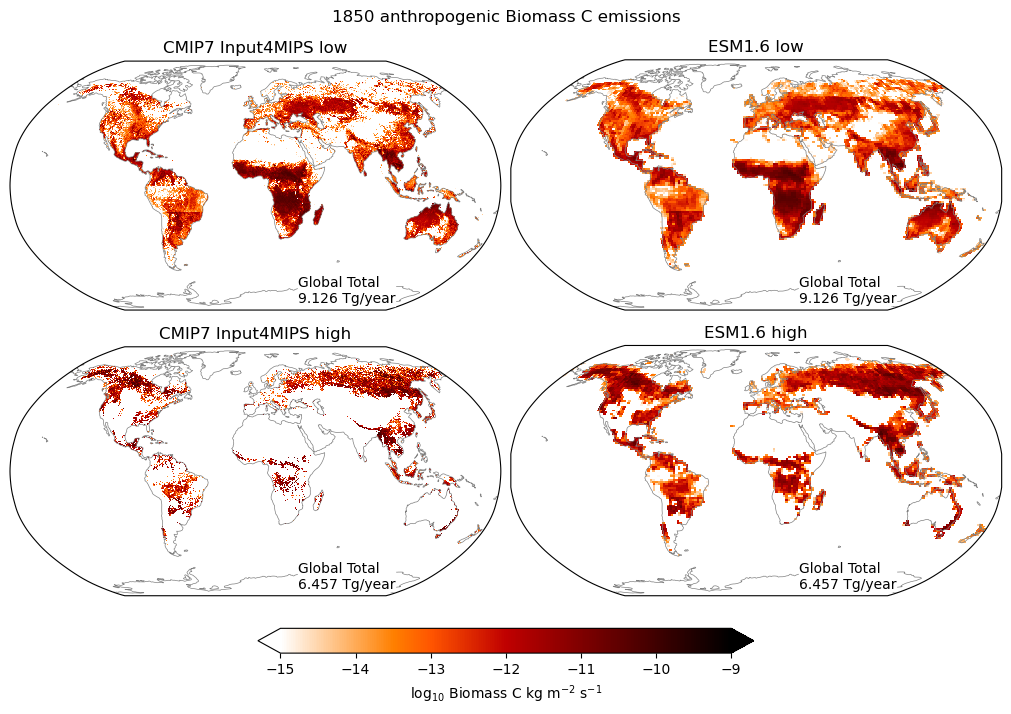

In [45]:
fig, axes = plt.subplots(2,2,layout='constrained', figsize=(10,7),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic Biomass C emissions')
vmin = -15
vmax= -9
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [bb_lo_cmip7_a[0], bb_esm16_lo_a[0], bb_hi_cmip7_a[0], bb_esm16_hi_a[0]]
label = ['CMIP7 Input4MIPS low', 'ESM1.6 low', 'CMIP7 Input4MIPS high', 'ESM1.6 high']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ Biomass C kg m$^{-2}$ s$^{-1}$')

savefig('biomass_emissions_cmip7_hilo.png')

print(f"CMIP7 low {annfac*itools.global_sum(data[0]).data:.3f}")
print(f"CMIP7 high {annfac*itools.global_sum(data[2]).data:.3f}")
print(f"ESM1.6 low {annfac*itools.global_sum(data[1]).data:.3f}")
print(f"ESM1.6 high {annfac*itools.global_sum(data[3]).data:.3f}")


In [47]:
# Met Office did not include SO2 from biomass burning in CMIP6
# https://code.metoffice.gov.uk/trac/ancil/ticket/627
bb_so2_cmip7 = iris.load_cube(cmip7_bb_path('SO2'), constraint_1850)

bb_so2_cmip7_a = itools.annual_mean(bb_so2_cmip7)
bb_so2_cmip7_a.coord('latitude').coord_system = iris.coord_systems.GeogCS(6371229.0)
bb_so2_cmip7_a.coord('longitude').coord_system = iris.coord_systems.GeogCS(6371229.0)

/g/data/xp65/public/apps/med_conda/envs/analysis3-25.05/lib/python3.11/site-packages/iris/fileformats/cf.py:880: IrisCfMissingVarWarning: Missing CF-netCDF measure variable 'gridcellarea', referenced by netCDF variable 'SO2'
  warnings.warn(


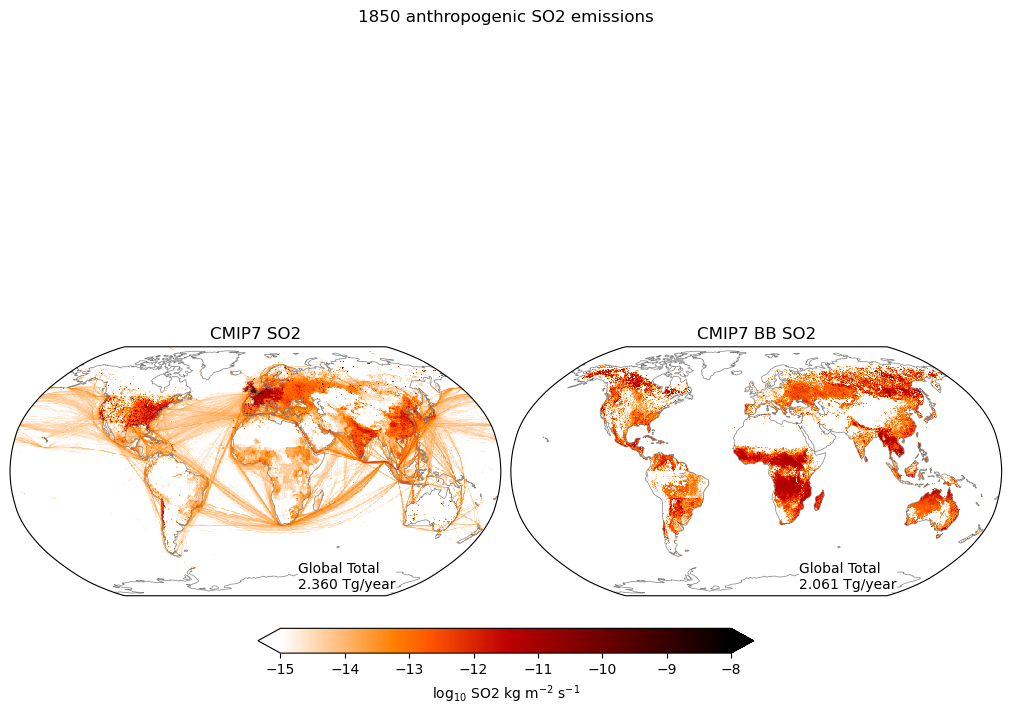

In [ ]:
fig, axes = plt.subplots(1,2,layout='constrained', figsize=(10,4),subplot_kw={'projection': ccrs.Robinson()})
axes = axes.flatten()

fig.suptitle('1850 anthropogenic SO2 emissions')
vmin = -15
vmax= -8
annfac = 365 * 86400 * 1e-9  # To get Tg

# Data to plot
data = [so2_lo_cmip7_a +so2_hi_cmip7_a, bb_so2_cmip7_a]
label = ['CMIP7 SO2', 'CMIP7 BB SO2']

for i, ax in enumerate(axes):
    ax.coastlines(color='gray', lw=0.5)
    # p = np.log10(data[i]).plot(ax=ax,transform=ccrs.PlateCarree(), add_colorbar=False, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    p = iplt.pcolormesh(iris.analysis.maths.log10(data[i][0]), axes=ax, cmap='gist_heat_r', vmin=vmin, vmax=vmax)
    ax.set_title(label[i])
    ax.text(50, -80, f"Global Total\n{annfac*itools.global_sum(data[i][0]).data:.3f} Tg/year",
            transform=ccrs.PlateCarree(),
            bbox={'facecolor':'white', 'edgecolor':'white', 'pad':0})

cbar = fig.colorbar(p, ax=axes, orientation='horizontal', extend='both', shrink=0.5)
cbar.set_label(label='log$_{10}$ SO2 kg m$^{-2}$ s$^{-1}$')
